In [551]:
import numpy as np
import osr_methods as osr
import line_search_methods as lsm
import ocr_methods as ocr
import matplotlib.pyplot as plt
import numdifftools as nd
from timeit import default_timer as timer

### Definição do Ponto Inicial

In [552]:
#exterior
#x = np.array([1., 15.])

#interior
x = np.array([4., 25.])

### Escolha dos métodos de OSR e OCR

In [553]:
# Metodos OCR
# 1 - Penalidade
# 2 - Barreira
metodo_ocr = 2

if (metodo_ocr == 1):
    n_met_ocr = "Penalidade"
elif (metodo_ocr == 2):
    n_met_ocr = "Barreira"

# Metodos OSR
# 1 - Univariante
# 2 - Powell
# 3 - Stepest Descent
# 4 - Newton-Raphson
# 5 - Fletcher-Reeves
# 6 - BFGS
metodo_osr = 4

if (metodo_osr == 1):
    n_met = 'Univariante'
elif (metodo_osr == 2):
    n_met = 'Powell'
elif (metodo_osr == 3):
    n_met = 'Steepest Descent'
elif (metodo_osr == 4):
    n_met = 'Newton-Raphson'
elif (metodo_osr == 5):
    n_met = 'Fletcher-Reeves'
elif (metodo_osr == 6):
    n_met = 'BFGS'

### Controle Numérico

In [554]:
# numero maximo de iteracoes na OSR
maxiter = 1000

# tolerancia para convergencia do gradiente na OSR
tol_conv = 1E-3

# tolerancia para a busca unidirecional na OSR
tol_search = 1E-8

# delta alpha do passo constante na OSR
line_step = 1E-4

#epsilon da maquina
eps = 1E-10

#parametros ocr
if metodo_ocr == 1:
    #penalidade
    r = 1E-7
    beta = 10
elif metodo_ocr == 2:
    #barreira
    r = 1E+7
    beta = 0.1

#tolerancia OCR
tol = 1E-3

ctrl_num_osr = [maxiter, tol_conv, tol_search, line_step, eps]

### Definição de f

In [555]:
def f(x):
    rho = 0.3
    B = 30
    t = 0.1
    return 2*rho*np.pi*x[0]*t*np.sqrt(x[1]**2 + B**2)

def grad_f(x):
    rho = 0.3
    B = 30
    t = 0.1
    return 2*rho*np.pi*t*np.array([np.sqrt(x[1]**2 + B**2), x[0]*(1/2)*2*x[1]*((x[1]**2 + B**2)**(-1/2))])

def hess_f(x):
    rho = 0.3
    B = 30
    t = 0.1
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = rho*np.pi*t*np.array([0., 2*x[1]*((x[1]**2 + B**2)**(-1/2))])
    hess[1,:] = rho*np.pi*t*np.array([2*x[1]*((x[1]**2 + B**2)**(-1/2)), 2*x[0]*((-1/2)*2*x[1]**2*(x[1]**2 + B**2)**(-3/2) + np.sqrt(x[1]**2 + B**2))])
    return hess

### Definição das restrições de desigualdade

In [556]:
def cl1(x):
    P = 33000
    B = 30
    t = 0.1
    sigmay = 1E+5
    return P*np.sqrt(x[1]**2 + B**2)/(np.pi*x[0]*t*x[1]) - sigmay

def grad_cl1(x):
    P = 33000
    B = 30
    t = 0.1
    return np.array([-P*np.sqrt(x[1]**2 + B**2)/(np.pi*t*x[1]*x[0]**2), -P*(B**2)/(np.pi*t*x[0]*x[1]**2*np.sqrt(x[1]**2 + B**2))])

def hess_cl1(x):
    P = 33000
    B = 30
    t = 0.1
    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([2*P*np.sqrt(x[1]**2 + B**2)/(t*np.pi*x[1]*x[0]**3), P*np.sqrt(x[1]**2 + B**2)/(t*np.pi*x[0]**2*x[1]**2) - P/(t*np.pi*x[0]**2*np.sqrt(x[1]**2 + B**2))])
    hess[1,:] = np.array([P*np.sqrt(x[1]**2 + B**2)/(t*np.pi*x[0]**2*x[1]**2) - P/(t*np.pi*x[0]**2*np.sqrt(x[1]**2 + B**2)), -P/(t*np.pi*x[0]*x[1]*np.sqrt(x[1]**2 + B**2)) - P*x[1]/(t*np.pi*x[0]*(x[1]**2 + B**2)**(3/2)) + 2*P*np.sqrt(x[1]**2 + B**2)/(t*np.pi*x[0]*x[1]**3)])
    return hess

def cl2(x):
    P = 33000
    B = 30
    t = 0.1
    E = 3E+7
    
    sigma =  P*np.sqrt(x[1]**2 + B**2)/(np.pi*x[0]*t*x[1])
    sigma_CR = np.pi**2*E*(x[0]**2 + t**2)/(8*(x[1]**2 + B**2))
    
    return sigma - sigma_CR

def grad_cl2(x):
    P = 33000
    B = 30
    t = 0.1
    E = 3E+7
    return np.array([-P*np.sqrt(x[1]**2 + B**2)/(np.pi*t*x[0]**2*x[1]) - E*np.pi**2*x[0]/(4*(x[1]**2 + B**2)), E*np.pi**2*x[1]*(t**2 + x[0]**2)/(4*(x[1]**2 + B**2)**2) - B**2*P/(np.pi*t*x[0]*x[1]**2*np.sqrt(x[1]**2 + B**2))])

def hess_cl2(x):
    #extraido do sympy
    P = 33000
    B = 30
    t = 0.1
    E = 3E+7
    
    a = -E*np.pi**2/(4*(B**2 + x[1]**2)) + 2*P*np.sqrt(B**2 + x[1]**2)/(np.pi*t*x[0]**3*x[1])
    b = E*np.pi**2*x[0]*x[1]/(2*(B**2 + x[1]**2)**2) - P/(np.pi*t*x[0]**2*np.sqrt(B**2 + x[1]**2)) + P*np.sqrt(B**2 + x[1]**2)/(np.pi*t*x[0]**2*x[1]**2)
    c = b
    d = -E*np.pi**2*x[1]**2*(t**2 + x[0]**2)/(B**2 + x[1]**2)**3 + E*np.pi**2*(t**2 + x[0]**2)/(4*(B**2 + x[1]**2)**2) - P*x[1]/(np.pi*t*x[0]*(B**2 + x[1]**2)**(3/2)) - P/(np.pi*t*x[0]*x[1]*np.sqrt(B**2 + x[1]**2)) + 2*P*np.sqrt(B**2 + x[1]**2)/(np.pi*t*x[0]*x[1]**3)

    hess = np.zeros((2,2), dtype=float)
    hess[0,:] = np.array([a, b])
    hess[1,:] = np.array([c, d])
    return hess

# def hess_cl2(x):
#     P = 33000
#     B = 30
#     t = 0.1
#     E = 3E+7
#     hess = np.zeros((2,2), dtype=float)
    
#     #termo 1x1
#     a_1 = 2*P*np.sqrt(x[1]**2 + B**2)/(np.pi*t*x[0]**3*x[1])
#     a_2 = -2*E*np.pi**2/(B**2 + 8*x[1]**2)
    
#     #termo 1x2
#     b_1 = P*np.sqrt(x[1]**2 + B**2)/(np.pi*t*x[0]**2*x[1]**2) 
#     b_2 = - P/(np.pi*t*x[0]**2*np.sqrt(x[1]**2 + B**2))
#     b_3 = 32*E*np.pi**2*x[0]*x[1]/((B**2 + 8*x[1]**2)**2)
    
#     #termo 2x1 = termo 1x2
#     c_1 = b_1
#     c_2 = b_2
#     c_3 = b_3
    
#     #termo 2x2
#     d_1 = -512*E*np.pi**2*x[1]**2*(t**2 + x[0]**2)/((B**2 + 8*x[1]**2)**3)
#     d_2 = 16*E*np.pi**2*(t**2 + x[0]**2)/((B**2 + 8*x[1]**2)**2)
#     d_3 = -P*x[1]/(np.pi*t*x[0]*(B**2 + x[1]**2)**(3/2))
#     d_4 = -P/(np.pi*t*x[0]*x[1]*np.sqrt(x[1]**2 + B**2))
#     d_5 = 2*P*np.sqrt(x[1]**2 + B**2)/(np.pi*t*x[0]*x[1]**3)
    
#     hess[0,:] = np.array([a_1 + a_2, b_1 + b_2 + b_3])
#     hess[1,:] = np.array([c_1 + c_2 + c_3, d_1 + d_2 + d_3 + d_4 + d_5])
    
#     return hess

### Listas de Restrições e suas derivadas

In [557]:
hk_list = []
grad_hk_list = []
hess_hk_list = []

cl_list = [cl1, cl2]
grad_cl_list = [grad_cl1, grad_cl2]
hess_cl_list = [hess_cl1, hess_cl2]

#para o metodo de penalidade
#controle de quais cls irao montar a phi
cl_mont = []
if metodo_ocr == 1:
    for cl in cl_list:
        if cl(x) > 0:
            cl_mont.append(1)
        else:
            cl_mont.append(0)
            
params = [f, grad_f, hess_f, hk_list, grad_hk_list, hess_hk_list, cl_list, grad_cl_list, hess_cl_list, cl_mont]


### Otimização

In [558]:

if metodo_ocr == 1:
    parc = (1/2)*r*ocr.p_penal(x, params)
elif metodo_ocr == 2:
    parc = r*ocr.b_bar(x, params)
    
listP_OCR = []
listP_OCR.append(x)

listResultsOSR = []

passos_OCR = 0
redo = 0
print(n_met)
while(parc > tol):
    passos_OCR = passos_OCR + 1
    if passos_OCR > 1:
        r = beta*r
        # for i in np.arange(len(levellist)):
        #     levellist[i] = beta*levellist[i]
        params[-1] = []
        for cl in cl_list:
            if cl(x) > 0:
                params[-1].append(1)
            else:
                params[-1].append(0)
    listP_OSR, passos_OSR, conv_OSR, flag_conv_OSR, tempoExec_OSR = osr.osr_ctrl(x, params, r, ctrl_num_osr, metodo_ocr, metodo_osr)
    
    if metodo_ocr == 2:
        redo = 0
        for cl in cl_list:
            if cl(listP_OSR[-1]) > 0:
                redo = 1
                break
    if (redo == 0):
        ctrl_num_osr[3] = line_step
        x = listP_OSR[-1]
        listP_OCR.append(x)
        listResultsOSR.append([listP_OSR, params, r, metodo_ocr, metodo_osr])
        if metodo_ocr == 1:
            parc = (1/2)*r*ocr.p_penal(x, params)
        elif metodo_ocr == 2:
            parc = r*ocr.b_bar(x, params)
        print(f'{passos_OCR}: x={x}, r={r:.1e}, passos={passos_OSR}, conv_OCR={parc:.4e}, conv_OSR={conv_OSR:.4e}')
    elif (redo == 1):
        print(f'Refazendo passo {passos_OCR} com delta alpha = {0.1*ctrl_num_osr[3]}')
        passos_OCR = passos_OCR - 1
        r = r/beta
        ctrl_num_osr[3] = 0.1*ctrl_num_osr[3]
        
        
        plt.close()
    

Newton-Raphson
1: x=[ 7.49664665 22.87917136], r=1.0e+07, passos=203, conv_OCR=1.3700e+02, conv_OSR=9.9916e-04
2: x=[ 3.66615031 22.26777546], r=1.0e+06, passos=3, conv_OCR=2.2498e+01, conv_OSR=5.5297e-04
3: x=[ 2.39329106 22.20410358], r=1.0e+05, passos=3, conv_OCR=5.0844e+00, conv_OSR=6.7830e-05
4: x=[ 2.02170438 21.48361066], r=1.0e+04, passos=5, conv_OCR=1.3810e+00, conv_OSR=4.5302e-04
5: x=[ 1.9199713  20.76917205], r=1.0e+03, passos=9, conv_OCR=4.0814e-01, conv_OSR=3.5602e-04
6: x=[ 1.89102087 20.42505391], r=1.0e+02, passos=9, conv_OCR=1.2565e-01, conv_OSR=5.1001e-04
7: x=[ 1.8823078  20.29859639], r=1.0e+01, passos=9, conv_OCR=3.9370e-02, conv_OSR=4.5745e-04
8: x=[ 1.87960037 20.25665455], r=1.0e+00, passos=7, conv_OCR=1.2411e-02, conv_OSR=9.5441e-04
9: x=[ 1.8787494  20.24317078], r=1.0e-01, passos=7, conv_OCR=3.9216e-03, conv_OSR=5.6628e-05
10: x=[ 1.87848074 20.23889114], r=1.0e-02, passos=5, conv_OCR=1.2397e-03, conv_OSR=2.1273e-04
11: x=[ 1.87839583 20.23753542], r=1.0e-03

### Plots de $\phi(x_1,x_2)$ e restrições

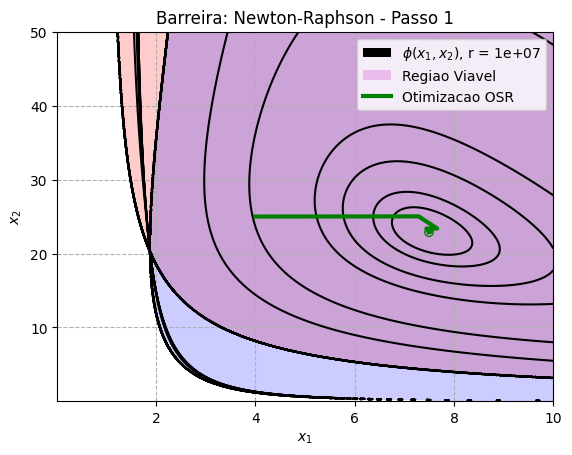

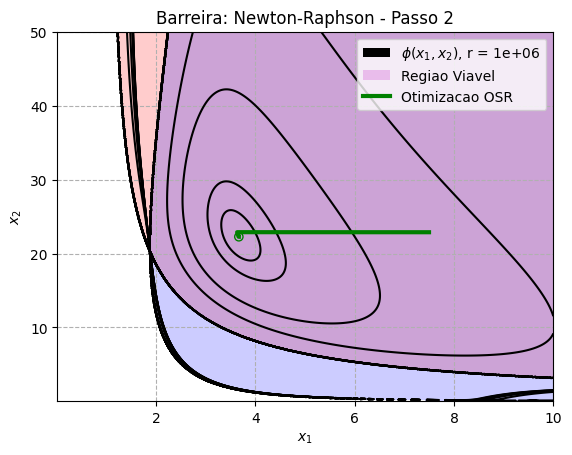

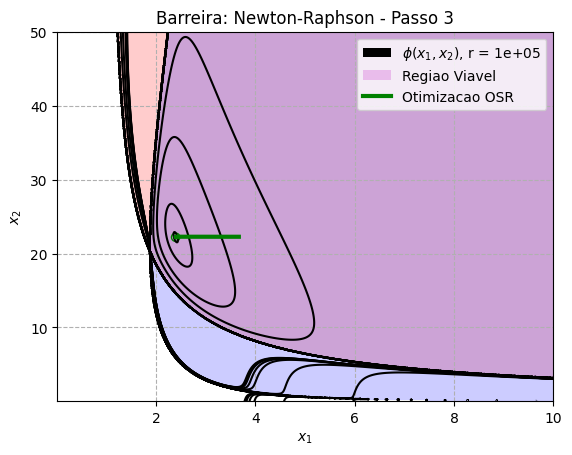

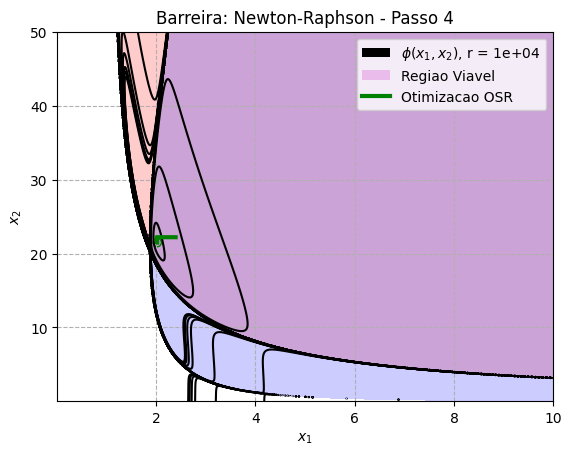

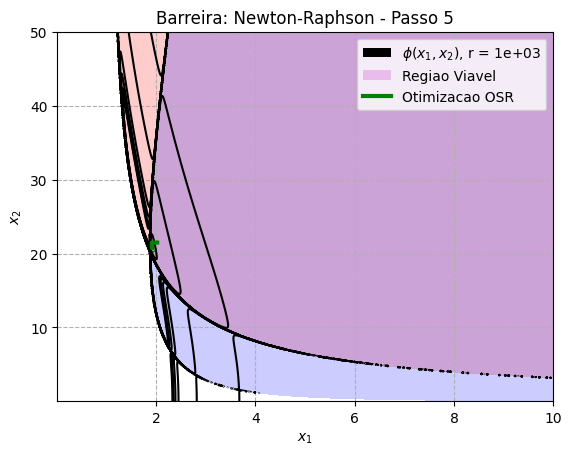

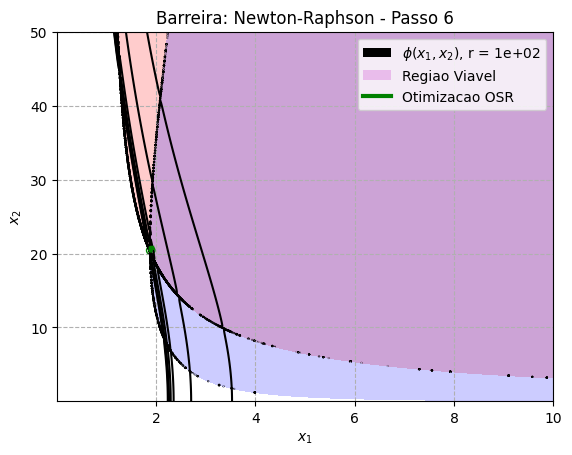

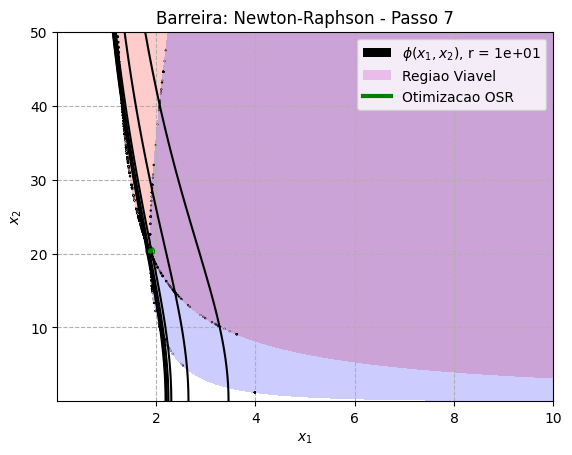

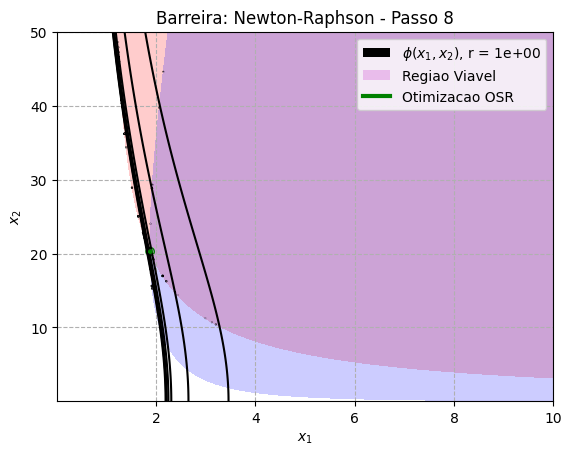

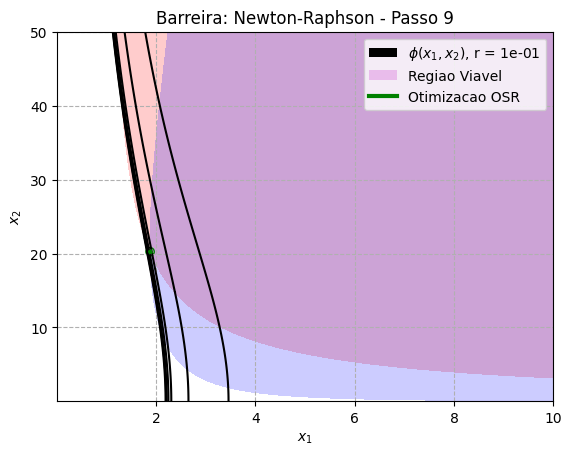

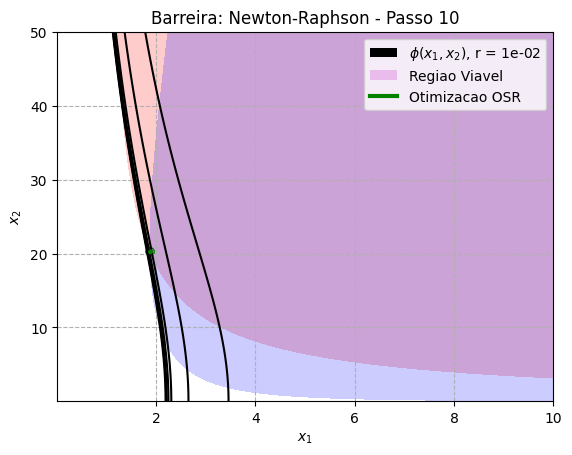

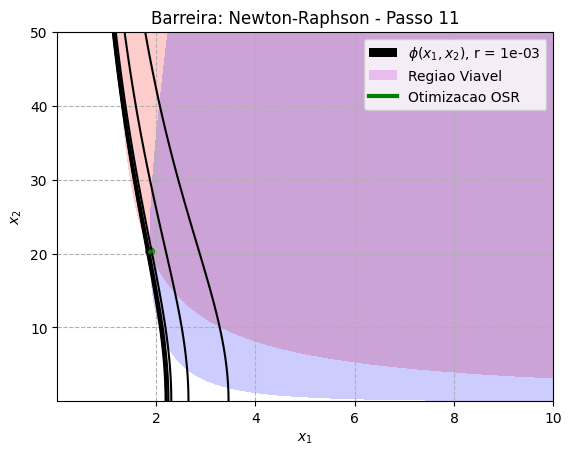

In [559]:
x1 = np.linspace(0.01,10, 2000)
x2 = np.linspace(0.01,50, 2000)
X1, X2 = np.meshgrid(x1, x2)

levellist = [190,191,192,195, 200, 230, 300]
multipliers = [0.25, 0.45, 0.7, 0.88, 0.96, 0.98, 1, 1, 1, 1, 1 ]
k = 0
for item in listResultsOSR :
    
    fig, ax = plt.subplots()
    #print(ocr.phi_bar(item[0][-1], item[1], item[2]))
    if metodo_ocr == 1:
        X3 = ocr.phi_penal([X1,X2], item[1], item[2])
        
    elif metodo_ocr == 2:
        X3 = ocr.phi_bar([X1, X2], item[1], item[2])
       
    niveis = ax.contour(X1, X2, X3, levellist, colors='black')
    #ax.clabel(niveis, inline=1, fontsize=8)
      
    X3 = cl1([X1,X2])
    ax.contourf(X1, X2, X3, [-100000, 0], colors='red', alpha=0.2)

    X3 = cl2([X1,X2])
    plt.contourf(X1, X2, X3, [-10000000, 0], colors='blue', alpha=0.2)
          
    x = []
    y = []
    for P in item[0]:
        x.append(P[0])
        y.append(P[1])
    line3, = ax.plot(x, y, color='g', linewidth='3')
    ax.scatter(item[0][-1][0], item[0][-1][1], color='green',marker='o', facecolors='none')
    ax.set_xlabel('$x_1$', fontsize='10')
    ax.set_ylabel('$x_2$', fontsize='10')   
    
    proxy = [plt.Rectangle((0,0),1,1,fc = 'black'), plt.Rectangle((0,0),1,1,fc = 'm', alpha=0.2), line3]    
    ax.legend(proxy, [f'$\phi(x_1,x_2)$, r = {item[2]:.0e}', 'Regiao Viavel', 'Otimizacao OSR'], loc='upper right')
       
    ax.grid(linestyle='--')
    titulo = n_met_ocr + ': ' + n_met + ' - ' + 'Passo ' + str(k+1)
    ax.set_title(titulo, fontsize=12)
    
    for i in np.arange(len(levellist)):
        levellist[i] = multipliers[k]*levellist[i]
    
    k = k+1
    
    

plt.show()

### Plot de $f(x_1, x_2)$ e restrições

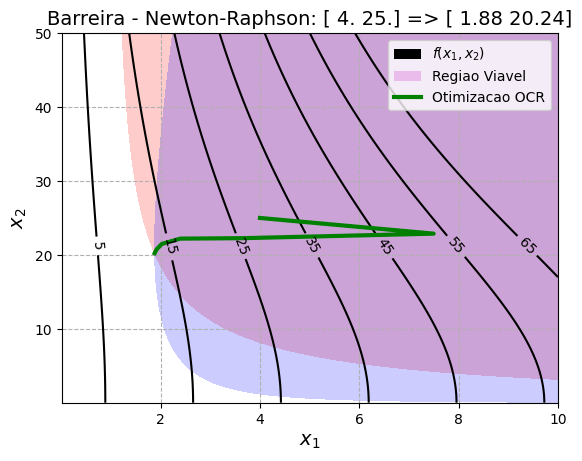

In [560]:
x1 = np.linspace(0.01,10, 2000)
x2 = np.linspace(0.01,50, 2000)
X1, X2 = np.meshgrid(x1, x2)
levellist = [5,15,25,35,45,55,65]

X3 = f([X1, X2])
    
figura, ax = plt.subplots()
        
niveis = ax.contour(X1, X2, X3, levellist, colors='black')
ax.clabel(niveis, inline=1, fontsize=10)

X3 = cl1([X1,X2])
ax.contourf(X1, X2, X3, [-100000, 0], colors='red', alpha=0.2)

X3 = cl2([X1,X2])
plt.contourf(X1, X2, X3, [-10000000, 0], colors='blue', alpha=0.2)
    
x = []
y = []
for P in listP_OCR:
    x.append(P[0])
    y.append(P[1])

line3, = ax.plot(x, y, color='g', linewidth='3')

proxy = [plt.Rectangle((0,0),1,1,fc = 'black'), plt.Rectangle((0,0),1,1,fc = 'm', alpha=0.2), line3]    
ax.legend(proxy, [f'$f(x_1,x_2)$', 'Regiao Viavel', 'Otimizacao OCR'], loc='upper right')

ax.set_xlabel('$x_1$', fontsize='14')
ax.set_ylabel('$x_2$', fontsize='14')
ax.grid(linestyle='--')
titulo = n_met_ocr + ' - ' + n_met + ': ' + np.array2string(listP_OCR[0], precision = 2, separator=' ') + ' => ' + np.array2string(listP_OCR[-1], precision = 2, separator=' ') 
ax.set_title(titulo, fontsize='14')
plt.show()